<a href="https://colab.research.google.com/github/sorennelson/Salt-Lake-City-Coronavirus-Analysis/blob/master/Salt_Lake_Coronavirus_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [0]:
file_path = 'drive/My Drive/Colab Notebooks/Coronavirus/'
states_file = 'us_states_covid19_daily.csv' # taken from https://www.kaggle.com/sudalairajkumar/covid19-in-usa
counties_file = 'us-counties.csv' # taken from https://github.com/nytimes/covid-19-data
pop_file = 'worldcities.csv' # taken from https://simplemaps.com/data/world-cities
us_pop_file = 'us-state-pop.csv' # takend from https://worldpopulationreview.com/states
world_file = 'world_covid_19_data.csv' # taken from https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset

## Salt Lake Coronavirus Cases

In [0]:
state_data = pd.read_csv(file_path + states_file)
state_pop = pd.read_csv(file_path + us_pop_file)
county_data = pd.read_csv(file_path + counties_file)
world_population = pd.read_csv(file_path + pop_file)
world_corona_data = pd.read_csv(file_path + world_file)

utah_data = state_data[state_data['state'] ==  'UT']
utah_county_data = county_data[county_data['state'] ==  'Utah']
sl_county_data = county_data[county_data['county'] ==  'Salt Lake']
web_county_data = county_data[county_data['county'] ==  'Weber']

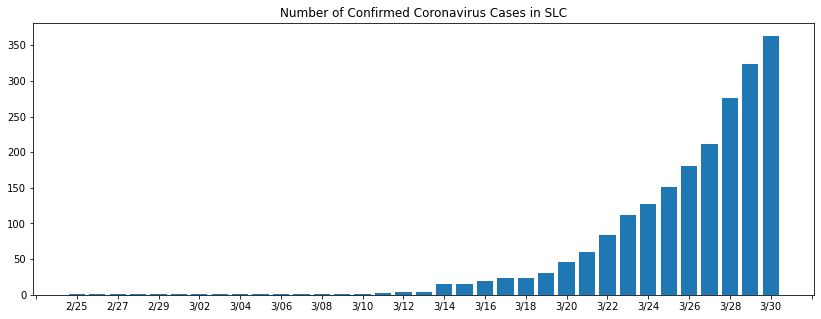

In [4]:
sl_dates = [i[-4] + '/' + i[-2:] for i in np.array(sl_county_data['date'])]
# web_dates = [i[-4] + '/' + i[-2:] for i in np.array(web_county_data['date'])]
plt.figure(figsize=(14,5))
plt.bar(sl_dates, np.array(sl_county_data['cases']))
# plt.bar(web_dates, np.array(web_county_data['cases']), label='Weber County Cases')

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.title('Number of Confirmed Coronavirus Cases in SLC')
# plt.legend()
plt.show()

## Similar City Populations

In [5]:
slc = world_population[world_population['city_ascii'] == 'Salt Lake City']
slc_pop = int(slc['population'].item())
print('Salt Lake City Population:', slc_pop)

Salt Lake City Population: 1098400


Get all cities in the world with populations between 500,000 and 2,500,000

In [0]:
sim_pop = range(slc_pop - 600000, slc_pop + 1400000)
sim_pops = world_population[world_population['population'].isin(sim_pop)]
city_pops_arr = np.array(sim_pops['city_ascii'])

Check which places have Coronavirus data

In [0]:
corona_city_arr = np.unique(np.array(world_corona_data['Province/State']).astype(str))
cleaned_corona_city = [city.split(',')[0] for city in corona_city_arr]
cleaned_corona_city = [city if city[0] != ' ' else city[1:] for city in cleaned_corona_city]

sim_corona_cities = []
for city in city_pops_arr:
  if city in cleaned_corona_city:
    sim_corona_cities.append(city)

clean_sim_corona_cities = []
for city in sim_corona_cities:
  for value in world_corona_data['Province/State'].values:
    if type(value) is str and city in value:
      clean_sim_corona_cities.append(value)
      break

US County data is more accurate so get that data for US Cities

In [0]:
sim_corona_cities = []
sim_counties = {'Bexar': 'San Antonio, TX', 'Multnomah': 'Portland, OR', 'Providence': 'Providence, RI', 'Sarasota': 'Sarasota, FL'}
sim_corona_data = []
sim_corona_dates = []
sim_death_data = []
longest_dates = (0, -1)
i = 0
for county, value in sim_counties.items():
  confirmed = np.array(county_data[county_data['county'] == county]['cases'])
  if sum(confirmed) == 0: continue
  sim_corona_data.append(confirmed)

  dates = np.array(county_data[county_data['county'] == county]['date'])
  sim_corona_dates.append(dates)
  if len(dates) > longest_dates[0]:
    longest_dates = (len(dates), i)
  i += 1

  deaths = np.array(county_data[county_data['county'] == county]['deaths'])
  sim_death_data.append(deaths)

  clean_sim_corona_cities.remove(value)
  sim_corona_cities.append(value)

Grab rest of cities

In [0]:
for city in clean_sim_corona_cities:
  confirmed = np.array(world_corona_data[world_corona_data['Province/State'] == city]['Confirmed'])
  if sum(confirmed) == 0:
    continue
  sim_corona_data.append(confirmed)

  dates = np.array(world_corona_data[world_corona_data['Province/State'] == city]['ObservationDate'])
  dates = np.array([i[6:] + '-' + i[:2] + '-' + i[3:5] for i in dates])
  sim_corona_dates.append(dates)
  if len(dates) > longest_dates[0]:
    longest_dates = (len(dates), i)
  i += 1

  deaths = np.array(world_corona_data[world_corona_data['Province/State'] == city]['Deaths'])
  sim_death_data.append(deaths)

  sim_corona_cities.append(city)

sim_corona_data[0], sim_corona_data[longest_dates[1]] = sim_corona_data[longest_dates[1]], sim_corona_data[0]
sim_death_data[0], sim_death_data[longest_dates[1]] = sim_death_data[longest_dates[1]], sim_death_data[0]
sim_corona_dates[0], sim_corona_dates[longest_dates[1]] = sim_corona_dates[longest_dates[1]], sim_corona_dates[0]

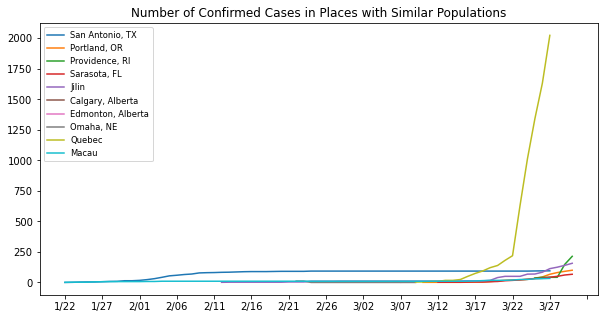

In [10]:
plt.figure(figsize=(10,5))

for i in range(len(sim_corona_cities)):
  if sim_corona_cities[i] == 'Omaha, NE (From Diamond Princess)': city = 'Omaha, NE'
  else: city = sim_corona_cities[i]
  dates = [j[-4] + '/' + j[-2:] for j in sim_corona_dates[i]]
  plt.plot(dates, sim_corona_data[i], label=city)

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.title('Number of Confirmed Cases in Places with Similar Populations')
plt.legend(fontsize='small')
plt.show()

Without the outlier (Quebec)

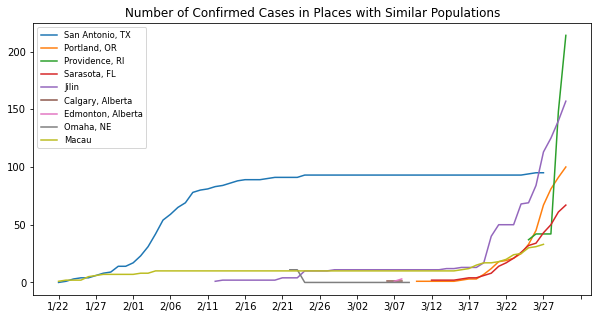

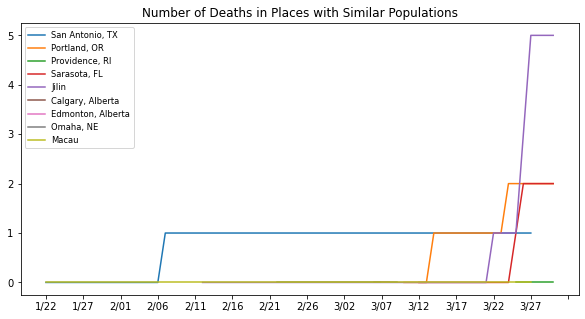

In [11]:
plt.figure(figsize=(10,5))

for i in range(len(sim_corona_cities)):
  if sim_corona_cities[i] == 'Quebec': continue
  if sim_corona_cities[i] == 'Omaha, NE (From Diamond Princess)': city = 'Omaha, NE'
  else: city = sim_corona_cities[i]
  dates = [j[-4] + '/' + j[-2:] for j in sim_corona_dates[i]]
  plt.plot(dates, sim_corona_data[i], label=city)

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.title('Number of Confirmed Cases in Places with Similar Populations')
plt.legend(loc=2, fontsize='small')
plt.show()


plt.figure(figsize=(10,5))

for i in range(len(sim_corona_cities)):
  if sim_corona_cities[i] == 'Quebec': continue
  if sim_corona_cities[i] == 'Omaha, NE (From Diamond Princess)': city = 'Omaha, NE'
  else: city = sim_corona_cities[i]
  dates = [j[-4] + '/' + j[-2:] for j in sim_corona_dates[i]]
  plt.plot(dates, sim_death_data[i], label=city)

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.title('Number of Deaths in Places with Similar Populations')
plt.legend(fontsize='small')
plt.show()



---



## Track places with a similar trajectory as Salt Lake over the past 7 days



In [12]:
cases = np.array(sl_county_data['cases'])
last7 = cases[-7:]
print('Salt Lake cases over last 7 days:', last7)
sl_slope = (last7[-1] - last7[0])/len(last7)
print('Salt Lake trajectory over last 7 days:', sl_slope)

Salt Lake cases over last 7 days: [127 151 181 212 276 324 363]
Salt Lake trajectory over last 7 days: 33.714285714285715


Gather cities with similar trajectory to Salt Lake over last 7 days at the about the same number of cases

In [0]:
def in_range(city_rows):
  data_rows = city_rows #[city_rows['Confirmed'] > 0]
  if len(data_rows) < 7: return None
  end_row = 7
  while len(data_rows) + 1 > end_row:
    cases = np.array(data_rows[end_row-7:end_row]['Confirmed'])
    slope = (cases[-1] - cases[0])/len(cases)
    if slope in range(int(sl_slope - 5), int(sl_slope + 6)) and cases[-1] < 500: return end_row
    end_row += 1
  return None

unique_world_cities = np.unique(np.array(world_corona_data['Province/State']).astype(str))
cities_in_range = []
cities_in_range_pop = []
cities_in_range_last_day = []

for city in unique_world_cities:
  city_rows = world_corona_data[world_corona_data['Province/State'] == city]
  date_range = in_range(city_rows)
  if date_range is not None:
    cities_in_range.append(city)
    cities_in_range_last_day.append(date_range)
    place_pop = np.array(state_pop[state_pop['State'] == city]['Pop'])
    if len(place_pop) > 0:
      cities_in_range_pop.append(str(round(place_pop[0] / 1000000., 2)))
    else:
      cities_in_range_pop.append('')

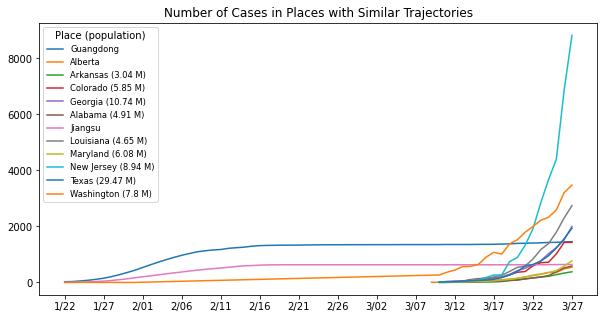

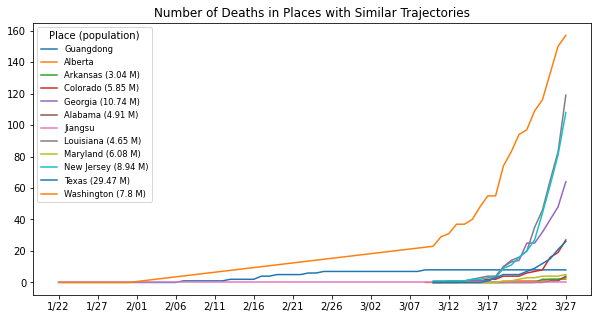

In [22]:
plt.figure(figsize=(10,5))

longest_city = (0, len(np.array(world_corona_data[world_corona_data['Province/State'] == cities_in_range[0]]['ObservationDate'])))
for i in range(1, len(cities_in_range)):
  city = cities_in_range[i]
  city_rows = world_corona_data[world_corona_data['Province/State'] == city]
  dates = np.array(city_rows['ObservationDate'])
  if len(dates) > longest_city[1]: longest_city = (i, len(dates))
cities_in_range[0], cities_in_range[longest_city[0]] = cities_in_range[longest_city[0]], cities_in_range[0]
cities_in_range_pop[0], cities_in_range_pop[longest_city[0]] = cities_in_range_pop[longest_city[0]], cities_in_range_pop[0]
cities_in_range_last_day[0], cities_in_range_last_day[longest_city[0]] = cities_in_range_last_day[longest_city[0]], cities_in_range_last_day[0]

for i in range(len(cities_in_range)):
  city = cities_in_range[i]
  city_rows = world_corona_data[world_corona_data['Province/State'] == city]

  dates = np.array(city_rows['ObservationDate'])
  dates = [j[6:] + '-' + j[:2] + '-' + j[3:5] for j in dates]
  dates = [j[-4] + '/' + j[-2:] for j in dates]
  if cities_in_range_pop[i] == '': label = city
  else: label = str(city + ' (' + cities_in_range_pop[i] + ' M)')
  plt.plot(dates, np.array(city_rows['Confirmed']), label=label)

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.title('Number of Cases in Places with Similar Trajectories')
plt.legend(title='Place (population)', title_fontsize='medium', fontsize='small')
plt.show()


plt.figure(figsize=(10,5))

for i in range(len(cities_in_range)):
  city = cities_in_range[i]
  city_rows = world_corona_data[world_corona_data['Province/State'] == city]

  dates = np.array(city_rows['ObservationDate'])
  dates = [j[6:] + '-' + j[:2] + '-' + j[3:5] for j in dates]
  dates = [j[-4] + '/' + j[-2:] for j in dates]
  if cities_in_range_pop[i] == '': label = city
  else: label = str(city + ' (' + cities_in_range_pop[i] + ' M)')
  plt.plot(dates, np.array(city_rows['Deaths']), label=label)

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.title('Number of Deaths in Places with Similar Trajectories')
plt.legend(title='Place (population)', title_fontsize='medium', fontsize='small')
plt.show()

## Using places with a similar trajectory, fit a regression model to predict Salt Lake's cases and deaths

In [0]:
X = np.zeros((len(cities_in_range), 1+len(np.array(sl_county_data['cases'])))) # [pop, confirmed w/same slope]
Y = np.zeros((len(cities_in_range)))
X_deaths = np.zeros((len(cities_in_range), 1+len(np.array(sl_county_data['cases']))))
Y_deaths = np.zeros((len(cities_in_range)))

X_wo_o = np.zeros((len(cities_in_range) - 1, 1+len(np.array(sl_county_data['cases'])))) # without outlier New Jersey
Y_wo_o = np.zeros((len(cities_in_range) - 1))

outlier = False
for i in range(len(cities_in_range)):
  city = cities_in_range[i]
  city_rows = world_corona_data[world_corona_data['Province/State'] == city]
  confirmed = np.array(city_rows['Confirmed'])
  deaths = np.array(city_rows['Deaths'])

  x = np.zeros((X.shape[1]))
  if cities_in_range_pop[i] != '': x[0] = int(float(cities_in_range_pop[i]) * 1000000)
  # x[1] = len(confirmed)
  x[0 - cities_in_range_last_day[i]:] = confirmed[:cities_in_range_last_day[i]]
  X[i] = x
  Y[i] = confirmed[-1]

  x_deaths = x.copy()
  x_deaths[0 - cities_in_range_last_day[i]:] = deaths[:cities_in_range_last_day[i]]
  X_deaths[i] = x_deaths
  Y_deaths[i] = deaths[-1]

  if city == 'New Jersey': 
    outlier = True
    continue
  j = i if not outlier else i - 1
  X_wo_o[j] = x
  Y_wo_o[j] = confirmed[-1]

Anywhere we don't have a population replace with median population

In [0]:
pop_avg = round(np.median(X[X[:,0] > 0][:,0]),2)
for i in range(len(cities_in_range)):
  if X[i,0] == 0: 
    X[i,0] = pop_avg
    X_deaths[i,0] = pop_avg

pop_avg_wo_o = round(np.median(X_wo_o[X_wo_o[:,0] > 0][:,0]),2)
for i in range(X_wo_o.shape[0]):
  if X_wo_o[i,0] == 0: 
    X_wo_o[i,0] = pop_avg

Fit Regression lines

In [0]:
reg = LinearRegression().fit(X, Y)
reg_deaths = LinearRegression().fit(X_deaths, Y_deaths)
reg_wo_o = LinearRegression().fit(X_wo_o, Y_wo_o)

Predict for Salt Lake

In [155]:
sl_cases = np.array(sl_county_data['cases'])
SL = np.zeros((1, X.shape[1]))
SL[0,0] = slc_pop
SL[0,0-len(sl_cases):] = sl_cases

print('Expected number of cases:', round(reg.predict(SL)[0],2))
print("Expected number of cases if we don't include the outlier:", round(reg_wo_o.predict(SL)[0],2))

sl_deaths = np.array(sl_county_data['deaths'])
SL_deaths = np.zeros((1, X.shape[1]))
SL_deaths[0,0] = slc_pop
SL_deaths[0,0-len(sl_deaths):] = sl_deaths

print('Expected number of deaths:', round(reg_deaths.predict(SL_deaths)[0],2))

Expected number of cases: 5268.24
Expected number of cases if we don't include the outlier: 3377.29
Expected number of deaths: 11.32


# Takeaways

Although having a much smaller population, Salt Lake's cases are growing at the same rate as Texas when it had under 500 cases. In places with a similar population, other than Quebec, Salt Lake has slightly more cases. However, Salt Lake has no deaths. 

Even though most other places that were at the same pace under 500 cases have grown immensely, since Salt Lake has a much smaller population and quarantined rather quickly in comparison, my analysis leads me to believe that it will only have a moderate amount of cases (\~5,000) and very few deaths (< 15).

*Note, the regression model was only trained on the data that had a similar trend as Salt Lake while under 500 cases. Also, we don't know the final number of cases anywhere, so this is an incomplete model and should be taken as such. Given that, I still believe this to be reasonable estimation of what's to come.*